Land Use and Land Cover

Objective

1. train a deep learning model for image classification using Pytorch
2. generate land use and land cover maps using Python GIS

Enabling GPU :GPUs currently available in Colab include Nvidia K80s, T4s, P4s and P100s

Key Task
1. classify satellite images into 10 LULC categories using the EuroSAT dataset
2. fine-tune a Resnet-50 CNN model for image classification
3. save and load trained models in Pytorch


In [1]:
# Standard libraries
import os
import random
from tqdm.notebook import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [3]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Data Description
In this section, you will learn how to:

1. Download the EuroSAT dataset into your Google Drive
2. Generate the train and test sets by splitting the EuroSAT dataset
3. Visualize a sample of the images and their LULC labels

## Eurosat Dataset

The EuroSAT dataset contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. Both RGB and multi-spectral (MS) images are available for download. For simplicity, we will focus on RGB image classification.

In [4]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2024-08-11 23:50:15--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  18.0MB/s    in 6.2s    

2024-08-11 23:50:22 (14.5 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



## Generate Train and Test Sets

In [5]:
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

## Image Normalization

In [6]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [7]:
# Load the dataset
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)

# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


## Split Train -Validation and Test Dataset

In [8]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 70% train / 15% val / 15% test
# by subsetting the transformed train and test datasets
train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 18900/4050/4050


Datloader operation


In [9]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

## Data Visualization

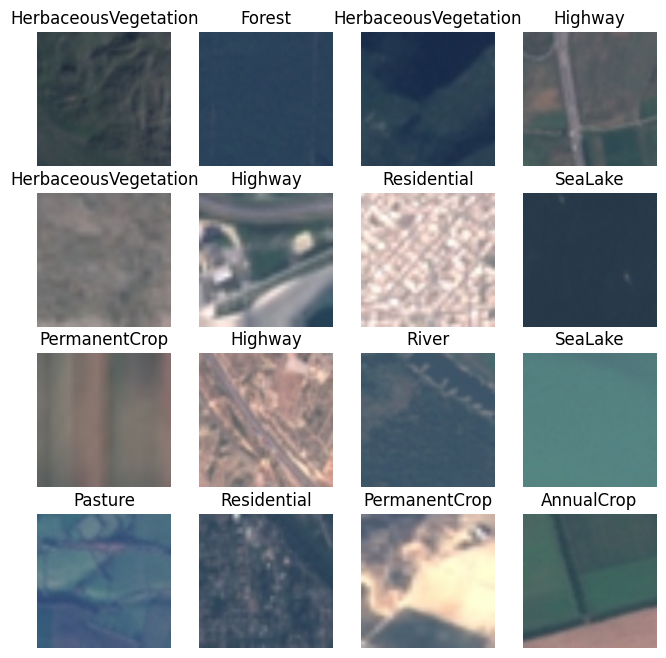

In [10]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

##Exploratory Data Analysis

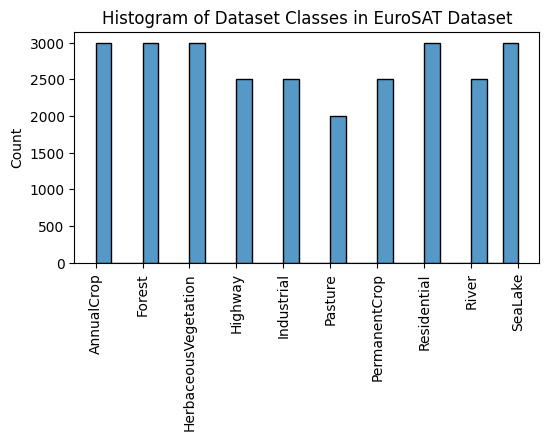

In [11]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)

hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

## Model Developement

To develop model , ResNet 50 will be used.

why ?

Recall: Deep neural networks are difficult to train due to the problem of vanishing or exploding gradients (repeated multiplication making the gradient infinitively small). ResNet solves this by using shortcut connections that connect activation from an earlier layer to a further layer by skipping one or more layers as shown below. This allows for gradients to propagate to the deeper layers before they can be reduced to small or zero values.

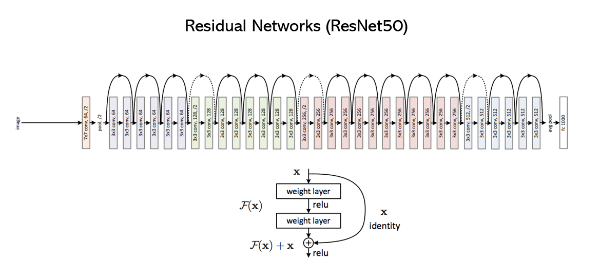

In [12]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
Train the model on the training set by updating its weights to minimize the loss function.
Evaluate the model on the test set to observe performance on new, unseen data.
Repeat steps 2 and 3 n_epochs times.

### Cross Entropy Loss
We define our loss as the cross-entropy loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. ([Source](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

For two classes, it is computed as:

$−ylog(p)-(1−y)log(1−p)$

For multiclass classification with $M$ classes, it is defined as:

$−\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$

where

- $M$ - number of classes (dog, cat, fish)
- $log$ - the natural log
- $y_{o,c}$ - binary indicator (0 or 1) if class label $c$ is the classification for observation $o$
- $p_{o,c}$- predicted probability observation $o$ is of class $c$

### Stochastic Gradient Descent
Remember that the goal of stochastic gradient descent (SGD) is to minimize the loss function. To do this, it computes the slope (gradient) of the loss function at the current point and moves in the opposite direction of the slope towards the steepest descent.
<center> <img src="https://miro.medium.com/max/1400/1*P7z2BKhd0R-9uyn9ThDasA.png" width="350"/><br>Image source:
<a href="https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a">https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a</a>
</center>
<br>

In [13]:
# Specify number of epochs and learning rate
n_epochs = 10
lr = 1e-3

# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

Training Function

In [14]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

Model Evaluation Function

In [15]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

Fit function for training and evaluating the model on the training set and validation data set respectively

In [16]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  # Keep track of the best loss and
  # best model weights with the lowest loss
  best_loss = np.inf
  best_model = None

  # Train and test over n_epochs
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

In [17]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.72; Accuracy: 50.15


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.24; Accuracy: 69.78
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.98; Accuracy: 70.62


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.69; Accuracy: 81.51
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.72; Accuracy: 77.30


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.53; Accuracy: 84.89
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.59; Accuracy: 81.33


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.34; Accuracy: 90.72
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.53; Accuracy: 82.98


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.29; Accuracy: 91.85
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.46; Accuracy: 85.09


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.23; Accuracy: 93.31
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.42; Accuracy: 86.44


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.20; Accuracy: 94.25
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.39; Accuracy: 87.18


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.18; Accuracy: 94.64
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.38; Accuracy: 87.89


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.16; Accuracy: 95.41
Epoch 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.36; Accuracy: 88.59


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.15; Accuracy: 95.31


Being GPU poor, testing only 10 epochs but can be done more to achive higher accuracy

## Model performance on the Test Set

In [18]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

  0%|          | 0/254 [00:00<?, ?it/s]

Test Loss: 0.15; Accuracy: 95.43


## Model Saving

In [19]:
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [20]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [21]:
save_model(best_model, model_file)

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth.


#Load the Model

In [22]:
def load_model(model_file):
  # Uncomment this to download the model file
  #if not os.path.isfile(model_file):
  #  model_file = 'best_model.pth'
  #  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

  model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
  model.fc = torch.nn.Linear(model.fc.in_features, 10)
  model.load_state_dict(torch.load(model_file))
  model.eval()

  print('Model file {} successfully loaded.'.format(model_file))
  return model

In [23]:
model = load_model(model_file)

Model file ./drive/My Drive/Colab Notebooks/models/best_model.pth successfully loaded.


## Results

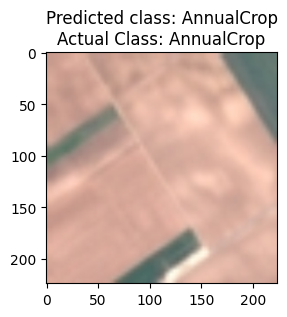

In [24]:
# Retrieve sample image
index = 15
image, label = test_data[index]

# Predict on sample
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

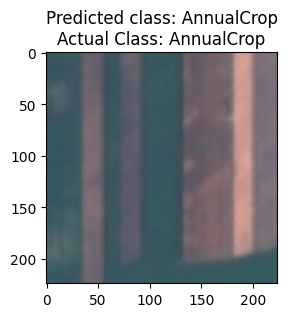

In [25]:
# Retrieve sample image
index = 25
image, label = test_data[index]

# Predict on sample
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

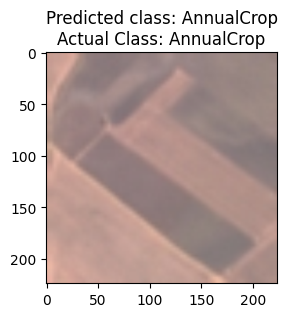

In [26]:
# Retrieve sample image
index = 45
image, label = test_data[index]

# Predict on sample
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

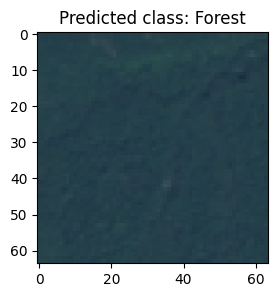

In [27]:
from PIL import Image
image_path = './EuroSAT/2750/Forest/Forest_2.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));

## Experiment with different fine tuning strategy

Freeze all but the final layers of a ResNet50 model. How does this finetuning strategy compare against the previous strategy?

In [28]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Add final (unfrozen) layer for classification
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

# Commence training
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.96; Accuracy: 44.74


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.77; Accuracy: 56.47
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.55; Accuracy: 59.31


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.56; Accuracy: 62.27
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.35; Accuracy: 63.81


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.40; Accuracy: 63.11
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.23; Accuracy: 66.59


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.25; Accuracy: 68.67
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.14; Accuracy: 68.72


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.22; Accuracy: 70.22
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.09; Accuracy: 69.53


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.22; Accuracy: 66.94
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.05; Accuracy: 69.68


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.10; Accuracy: 72.91
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.01; Accuracy: 70.71


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.01; Accuracy: 74.69
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.97; Accuracy: 71.88


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.00; Accuracy: 73.21
Epoch 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.96; Accuracy: 71.66


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.01; Accuracy: 73.04


## Experiment with different Imagenet-pretrained CNN models.

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.93; Accuracy: 72.40


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.00; Accuracy: 73.65
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.91; Accuracy: 72.42


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.93; Accuracy: 75.83
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.89; Accuracy: 73.20


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.92; Accuracy: 75.14
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.88; Accuracy: 73.23


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.87; Accuracy: 78.15
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.86; Accuracy: 73.52


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.87; Accuracy: 78.07
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.85; Accuracy: 73.98


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.87; Accuracy: 76.96
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.84; Accuracy: 74.26


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.87; Accuracy: 76.37
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.82; Accuracy: 74.62


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.83; Accuracy: 77.93
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.82; Accuracy: 74.82


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.84; Accuracy: 78.10
Epoch 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.81; Accuracy: 75.02


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.80; Accuracy: 78.79


In [29]:
## efficient net B0

In [31]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

# Modify the final layer for classification
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(dataset.classes))

model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 98.5MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [32]:
# Commence training
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.69; Accuracy: 53.17


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.22; Accuracy: 71.56
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.05; Accuracy: 70.24


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.70; Accuracy: 84.77
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.81; Accuracy: 75.80


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.49; Accuracy: 87.16
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.67; Accuracy: 78.94


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.38; Accuracy: 90.10
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.59; Accuracy: 81.21


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.29; Accuracy: 92.25
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.55; Accuracy: 82.78


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.24; Accuracy: 93.93
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.50; Accuracy: 84.06


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.22; Accuracy: 93.88
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.48; Accuracy: 85.00


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.18; Accuracy: 95.33
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.44; Accuracy: 85.85


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.18; Accuracy: 95.23
Epoch 10


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.42; Accuracy: 86.14


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.17; Accuracy: 94.57


## Experiment with Satellite Image-pretrained CNN models.

In [33]:
!pip install -q timm
!pip install -q torchgeo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.1/381.1 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.6/806.6 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 38.9 MB/s eta 0

In [34]:
import timm
from torchgeo.models import ResNet50_Weights

weights = ResNet50_Weights.SENTINEL2_RGB_MOCO
model = timm.create_model(
    "resnet50", in_chans=weights.meta["in_chans"],
    num_classes=len(dataset.classes)
)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://hf.co/torchgeo/resnet50_sentinel2_rgb_moco/resolve/efd9723b59a88e9dc1420dc1e96afb25b0630a3c/resnet50_sentinel2_rgb_moco-2b57ba8b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_moco-2b57ba8b.pth
100%|██████████| 90.0M/90.0M [00:12<00:00, 7.47MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Commence training
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 2.28; Accuracy: 28.29


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 2.24; Accuracy: 52.00
Epoch 2


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 2.19; Accuracy: 45.11


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 2.09; Accuracy: 50.27
Epoch 3


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.99; Accuracy: 46.65


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.68; Accuracy: 52.74
Epoch 4


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.67; Accuracy: 50.42


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.34; Accuracy: 67.36
Epoch 5


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.41; Accuracy: 58.31


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 1.10; Accuracy: 72.59
Epoch 6


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.21; Accuracy: 65.62


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.86; Accuracy: 81.56
Epoch 7


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 1.02; Accuracy: 71.80


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.62; Accuracy: 85.85
Epoch 8


  0%|          | 0/1182 [00:00<?, ?it/s]

Train Loss: 0.86; Accuracy: 76.20


  0%|          | 0/254 [00:00<?, ?it/s]

Val Loss: 0.45; Accuracy: 89.21
Epoch 9


  0%|          | 0/1182 [00:00<?, ?it/s]